# **Project2. Molecular property prediction using GCN**

Dataset: BACE


# **Library + hyperparameter setup**

In [1]:
# install rdkit and deepchem on colab environment
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem=2.1.0 python=3.6
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

--2019-12-25 12:24:28--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   277MB/s    in 0.2s    

2019-12-25 12:24:29 (277 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_

In [2]:
# import libraries
import deepchem as dc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import time
import math
import numpy as np
import scipy.sparse as sp
import networkx as nx
from rdkit import Chem
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc #for ECFP
from sklearn.ensemble import RandomForestClassifier #for ECFP
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# set hyperparameters
# BACE setting
hp = {}
hp['learning_rate'] = 1e-4
hp['epochs'] = 5
hp['batch_size'] = 32
hp['hidden1'] = 64
hp['hidden2'] = 128
hp['hidden3'] = 256
hp['hidden4'] = 512
hp['dropout'] = 0.2

print(hp)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

{'learning_rate': 0.0001, 'epochs': 5, 'batch_size': 32, 'hidden1': 64, 'hidden2': 128, 'hidden3': 256, 'hidden4': 512, 'dropout': 0.2}


# **Helper functions for GCN data handling**

In [0]:
def load_lists(dataset):
  # load data
  adj_list = []
  feat_list = []
  label_list = []
  
  for x, y, w, smiles in dataset.itersamples():

    smiles = Chem.MolFromSmiles(smiles)
    featurizer = dc.feat.ConvMolFeaturizer()
    features = featurizer.featurize([smiles])[0]

    edge_list = features.get_adjacency_list()
    atom_feature = features.get_atom_features() 

    # convert adjacency list into adjacency matrix "A"
    adj = np.zeros((len(edge_list), len(edge_list)))
    for i in range(len(edge_list)):
      for j in edge_list[i]:
        adj[i][j]=1
    adj_list.append(adj) # (num_atoms, num_atoms)
    feat_list.append(atom_feature) # (num_atoms, num_features=75)
    label_list.append(y) # 0/1

  return adj_list, feat_list, label_list

# f(H(l), A) = nonlinear(Dhat^-1/2 * Ahat * Dhat^-1/2 * H_l * W_l)
# preprocessing for recurrent interaction during convolution
def normalize_adj(adj):
  # add identity matrix
  adj_hat = adj + np.eye(adj.shape[0])
  # compute diagonal node degree matrix of Ahat
  deg = np.sum(adj_hat,axis=0)

  # sqrt inv
  deg_inv = np.divide(1, deg)
  deg_inv_sqrt = np.sqrt(deg_inv)
  deg_inv_diag = np.diag(np.squeeze(np.asarray(deg_inv_sqrt)))

  # normalize
  adj_norm = np.matmul(np.matmul(deg_inv_diag, adj_hat), deg_inv_diag)
  return adj_norm

In [0]:
# custom dataset class
class BaseDataset(Dataset):
  def __init__(self, adj_list, feat_list, label_list, train_mode=False):
    self.adj_list = adj_list
    self.feat_list = feat_list
    self.label_list = label_list
    self.train_mode = train_mode

  def __len__(self):
    return len(self.adj_list)
  
  def __getitem__(self, idx):
    # return graph, feature and label
    return adj_list[idx], feat_list[idx], label_list[idx]

  def get_tensors(self):
    # return batch tensors of normalized adjacency matrix, input and target
    # return tensor shape (batch_size, *)
    adj_list = self.adj_list
    feat_list = self.feat_list
    label_list = self.label_list

    # get maximum size for padding
    max_num_atom = -1
    for adj in adj_list:
      if adj.shape[0] > max_num_atom:
        max_num_atom = adj.shape[0]
    
    # make padded batch matrix of normalized adjacency matrix
    padded_adj_list = []
    for i, adj in enumerate(adj_list): # (num_atoms, num_atoms)
      adj_norm = normalize_adj(adj) # normalize
      # padding
      pad_num = max_num_atom - adj.shape[0]
      npad = ((0, pad_num), (0, pad_num))
      padded_adj = np.pad(adj_norm, npad, mode='constant', constant_values=0)
      # append
      padded_adj_list.append(padded_adj)
    # construct numpy array
    adj_np = np.stack(padded_adj_list, axis=0) # (batch_size, num_atoms, num_atoms)

    # make padded batch matrix of feature matrix
    padded_feat_list = []
    for i, feat in enumerate(feat_list): # (num_atoms, num_features=75)
      # padding
      pad_num = max_num_atom - feat.shape[0]
      npad = ((0, pad_num), (0, 0))
      padded_feat = np.pad(feat, npad, mode='constant', constant_values=0)
      # append
      padded_feat_list.append(padded_feat)
    # construct numpy array
    feat_np = np.stack(padded_feat_list, axis=0) # (batch_size, num_atoms, num_features=75)
    feat_np = np.transpose(feat_np, [0, 2, 1]) # (batch_size, num_features=75, num_atoms)

    # convert label list to numpy array
    label_np = np.asarray(label_list)

    adjs = torch.from_numpy(adj_np)
    inputs = torch.from_numpy(feat_np)
    targets = torch.from_numpy(label_np)

    del adj_list, feat_list, label_list, padded_adj_list, padded_feat_list

    return adjs, inputs, targets

In [0]:
# dataset constructor
def make_dataset(batch_size, adj_list, feat_list, label_list):
  # construct BaseDataset objects for each batch
  data_len = len(adj_list)

  begin = 0
  finished = 0
  dataset_list = []
  while(1):
    if begin + batch_size < data_len:
      end = begin + batch_size
      dataset_list.append(BaseDataset(adj_list[begin:end],
                                      feat_list[begin:end],
                                      label_list[begin:end],
                                      train_mode=True))
      begin += batch_size
    else:
      end = data_len
      dataset_list.append(BaseDataset(adj_list[begin:end],
                                      feat_list[begin:end],
                                      label_list[begin:end],
                                      train_mode=True))
      break
  return  math.ceil(data_len/batch_size), dataset_list

# **GCN model code**

In [0]:
# graph convolution layer
class GraphConvolution(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.p = dropout
    
    # feature weight matrix
    self.w = nn.Parameter(torch.empty(output_dim, input_dim))
    nn.init.xavier_uniform_(self.w)
    self.relu = nn.ReLU() # non-linearity
    self.dropout = nn.Dropout(p=self.p) # dropout

  def forward(self, x, adjs):
    # input, output tensor shapes: (batch_size, num_features, num_nodes)
    # adjs tensor shape: (batch_size, num_nodes, num_nodes)
    num_nodes = x.shape[2]
    if x.shape[1] != self.input_dim:
      print((x.shape[1], self.input_dim))
      raise RuntimeError("input feature dimension not matched to input_dim argument")

    x = x.type(torch.FloatTensor)
    adjs = adjs.type(torch.FloatTensor)

    # forward
    x = self.dropout(x)
    x = torch.transpose(x, 1, 2) # (batch_size, num_nodes, input_dim)
    w = torch.transpose(self.w, 0, 1) # (input_dim, output_dim)
    x = torch.einsum("abc,cd->abd", (x, w)) # (batch_size, num_nodes, output_dim)
    x = torch.transpose(x, 1, 2) # (batch_size, output_dim, num_nodes)
    o = torch.bmm(x, adjs) # (batch_size, output_dim, num_nodes)
    return o

class GCNModel(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hp = hp # hyperparameters
    hidden1 = self.hp['hidden1']
    hidden2 = self.hp['hidden2']
    hidden3 = self.hp['hidden3']
    hidden4 = self.hp['hidden4']
    p = self.hp['dropout']

    self.gc1 = GraphConvolution(input_dim=self.input_dim, output_dim=hidden1, dropout=p)
    self.gc2 = GraphConvolution(input_dim=hidden1, output_dim=hidden2, dropout=p)
    self.gc3 = GraphConvolution(input_dim=hidden2, output_dim=hidden3, dropout=p)
    self.gc4 = GraphConvolution(input_dim=hidden3, output_dim=hidden4, dropout=p)

    self.bn1 = nn.BatchNorm1d(num_features=hidden1)
    self.bn2 = nn.BatchNorm1d(num_features=hidden2)
    self.bn3 = nn.BatchNorm1d(num_features=hidden3)
    self.bn4 = nn.BatchNorm1d(num_features=hidden4)
    self.bn_fc = nn.BatchNorm1d(num_features=1)

    self.fc = nn.Linear(in_features=hidden4, out_features=1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=p)
    self.dropout_fc = nn.Dropout(p=0.5)
    
  def forward(self, x, adjs):
    # input tensor shape: (batch_size, input_dim, num_nodes)
    x = self.relu(self.dropout(self.bn1(self.gc1(x, adjs))))
    x = self.relu(self.dropout(self.bn2(self.gc2(x, adjs))))
    x = self.relu(self.dropout(self.bn3(self.gc3(x, adjs))))
    x = self.relu(self.dropout(self.bn4(self.gc4(x, adjs))))
    x = self.fc(self.dropout_fc(torch.mean(x, dim=2)))
    o = self.bn_fc(x)
    # output tensor shape: (batch_size, output_dim=1)
    return o

In [0]:
def train(model, train_batch_num, train_dataset_list, criterion):
  train_roc_score = 0.
  train_ap_score = 0.
  cnt = 0
  epoch_loss = 0.
  for idx in range(train_batch_num):
    train_dataset = train_dataset_list[idx]
    adjs, inputs, targets = train_dataset.get_tensors()
    output = model(inputs, adjs)

    loss = criterion(output, targets)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()

    targets = targets.clone().detach().numpy()
    output = output.clone().detach().numpy()
    output = 1 / (1 + np.exp(-output)) # sigmoid
    output = output > 0.5
    try:
      train_roc_score += roc_auc_score(targets, output)
      train_ap_score += average_precision_score(targets, output)
      cnt += 1
    except ValueError:
      pass
  
  train_roc_score /= cnt
  train_ap_score /= cnt
  epoch_loss /= train_batch_num
  return train_roc_score, train_ap_score, epoch_loss

def evaluate(valid_batch_num, model, valid_dataset_list):
  roc_score = 0.
  ap_score = 0.
  cnt = 0
  for idx in range(valid_batch_num):
    valid_dataset = valid_dataset_list[idx]
    adjs, inputs, targets = valid_dataset.get_tensors()
    output = model(inputs, adjs)

    targets = targets.clone().detach().numpy()
    output = output.clone().detach().numpy()
    output = 1 / (1 + np.exp(-output)) # sigmoid
    output = output > 0.5
    try:
      roc_score += roc_auc_score(targets, output)
      ap_score += average_precision_score(targets, output)
      cnt += 1
    except ValueError:
      pass
  
  roc_score /= cnt
  ap_score /= cnt
  return roc_score, ap_score

# **ECFP - random forest model**

In [0]:
### make helper functions for ECFP featurization ###
# function for getting ECFP feature
# input: train, validation, or test dataset
def loadECFP(dataset):
  # load data
  ECFP_feat = []
  ECFP_label = []
  for x, y, w, smiles in dataset.itersamples():
    ECFP_feat.append(x)
    ECFP_label.append(y)
  # return ECFP feature and its label (X___, Y___)
  return np.array(ECFP_feat), np.array(ECFP_label)

# ECFP model building funcion
# Randomly splitted data are used
def getAUCfromRF_model(X_train, Y_train, X_test, Y_test):
  # make randomforest classifier
  clf=RandomForestClassifier(n_estimators=100, criterion='entropy')
  # train with train set
  clf.fit(X_train, Y_train)
  fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test)[:, 1])
  # get auc score with test sets
  AUC = auc(fpr, tpr)
  return(AUC)

# **Main routine**

ours / BACE benchmark result

<div>
<img src=https://drive.google.com/uc?export=download&id=1fwfrIYCODTeWbJ0ioyNCQAFlZC8dB-Jj
 height="200"/>
<img src=https://drive.google.com/uc?export=download&id=1b5ElORQTxHG4NuxwMiX9zefd3WV6fCKT height="200"/>
</div>

In [9]:
# loop routine
seed_list = [33,84,35,31,48,42,59,53,54,51]
GCN_AUC_list = []
ECFP_AUC_list = []

for i in range(10):
  # set random seed
  seed = seed_list[i]
  np.random.seed(seed)
  torch.manual_seed(seed)

  # load dataset
  tasks, datasets, transformers = dc.molnet.load_bace_classification(featurizer='ECFP',
                                                                     split='scaffold')
  train_dataset, valid_dataset, test_dataset = datasets
  
  ###########################################################
  # GCN section
  ###########################################################

  # load lists
  train_adj_list, train_feat_list, train_label_list = load_lists(train_dataset)
  valid_adj_list, valid_feat_list, valid_label_list = load_lists(valid_dataset)
  test_adj_list, test_feat_list, test_label_list = load_lists(test_dataset)
  
  # construct datasets
  train_batch_num, train_dataset_list = make_dataset(batch_size = hp['batch_size'],
                                                     adj_list=train_adj_list,
                                                     feat_list=train_feat_list,
                                                     label_list=train_label_list)
  valid_batch_num, valid_dataset_list = make_dataset(batch_size = hp['batch_size'],
                                                     adj_list=valid_adj_list,
                                                     feat_list=valid_feat_list,
                                                     label_list=valid_label_list)
  test_batch_num, test_dataset_list = make_dataset(batch_size = hp['batch_size'],
                                                   adj_list=test_adj_list,
                                                   feat_list=test_feat_list,
                                                   label_list=test_label_list)
  # main training routine
  # define model
  num_features = train_feat_list[0].shape[1]
  model = GCNModel(input_dim = num_features)
  
  # set optimizer and loss
  optimizer = optim.Adam(model.parameters(), lr=hp['learning_rate'])
  criterion = nn.BCEWithLogitsLoss(reduction='mean')
  
  # optimization
  print("\ntrain start: %d" %(i+1))
  for epoch in range(hp['epochs']):
    t = time.time()
    model.train()
    train_roc_score, train_ap_score, epoch_loss = train(model,
                                                        train_batch_num,
                                                        train_dataset_list,
                                                        criterion)
    model.eval()
    roc_score, ap_score = evaluate(valid_batch_num, model, valid_dataset_list)
    print("epoch:", '%02d' % (epoch + 1),
          "train: [loss=", "{:.4f}".format(epoch_loss),
          "roc=", "{:.4f}".format(train_roc_score),
          "ap=", "{:.4f}".format(train_ap_score),
          "] val: [roc=", "{:.4f}".format(roc_score),
          "ap=", "{:.4f}".format(ap_score),
          "] t=", "{:.4f}".format(time.time() - t))
    
  print('optimization finished!')
  model.eval()
  roc_score, ap_score = evaluate(test_batch_num, model, test_dataset_list)
  print('Test ROC score: {:.5f}'.format(roc_score))
  print('Test AP score: {:.5f}'.format(ap_score))
  GCN_AUC_list.append(roc_score)

  del model, train_dataset_list, valid_dataset_list, test_dataset_list
  del tasks, datasets, transformers
  del train_adj_list, train_feat_list, train_label_list
  del valid_adj_list, valid_feat_list, valid_label_list
  del test_adj_list, test_feat_list, test_label_list

  ###########################################################
  # ECFP - random forest section
  ###########################################################

  # train, test data for ECFP
  X_train_E, Y_train_E = loadECFP(train_dataset)
  X_test_E, Y_test_E = loadECFP(test_dataset)
  
  # AUC list for ECFP
  ECFP_AUC = getAUCfromRF_model(X_train_E, Y_train_E, X_test_E, Y_test_E)
  ECFP_AUC_list.append(ECFP_AUC)

  del train_dataset, valid_dataset, test_dataset
  del X_train_E, Y_train_E, X_test_E, Y_test_E

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/bace.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.915 s
TIMING: dataset construction took 4.156 s
Loading dataset from disk.
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.039 s
Loading dataset from disk.
TIMING: dataset construction took 0.038 s
Loading dataset from disk.

train start: 1
epoch: 01 train: [loss= 0.8077 roc= 0.5074 ap= 0.6999 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.6643
epoch: 02 train: [loss= 0.7994 roc= 0.6276 ap= 0.7414 ] val: [roc= 0.5750 ap= 0.6813 ] t= 3.4225
epoch: 03 train: [loss= 0.8005 roc= 0.5535 ap= 0.7143 ] val: [roc= 0.5667 ap= 0.6625 ] t= 3.3993
epoch: 04 train: [loss= 0.7952 roc= 0.6545 ap= 0.7528 ] val: [roc= 0.5583 ap= 0.6600 ] t= 3.4268
epoch: 05 train: [loss= 0.7873 roc= 0.6818 ap= 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 2
epoch: 01 train: [loss= 0.8096 roc= 0.4713 ap= 0.6865 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3674
epoch: 02 train: [loss= 0.8013 roc= 0.5232 ap= 0.7084 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3496
epoch: 03 train: [loss= 0.8024 roc= 0.5420 ap= 0.7139 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.4120
epoch: 04 train: [loss= 0.7980 roc= 0.5643 ap= 0.7212 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3509
epoch: 05 train: [loss= 0.7929 roc= 0.6195 ap= 0.7440 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3309
optimization finished!
Test ROC score: 0.54301
Test AP score: 0.57901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 3
epoch: 01 train: [loss= 0.8112 roc= 0.3636 ap= 0.6588 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3167
epoch: 02 train: [loss= 0.7978 roc= 0.6488 ap= 0.7532 ] val: [roc= 0.5750 ap= 0.6813 ] t= 3.2904
epoch: 03 train: [loss= 0.8016 roc= 0.5396 ap= 0.7108 ] val: [roc= 0.5750 ap= 0.6635 ] t= 3.2861
epoch: 04 train: [loss= 0.7984 roc= 0.4810 ap= 0.6927 ] val: [roc= 0.5167 ap= 0.6330 ] t= 3.3126
epoch: 05 train: [loss= 0.7950 roc= 0.6797 ap= 0.7751 ] val: [roc= 0.5917 ap= 0.6785 ] t= 3.2462
optimization finished!
Test ROC score: 0.57710
Test AP score: 0.61234


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 4
epoch: 01 train: [loss= 0.8111 roc= 0.3936 ap= 0.6669 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2854
epoch: 02 train: [loss= 0.8013 roc= 0.6095 ap= 0.7487 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2915
epoch: 03 train: [loss= 0.8008 roc= 0.5064 ap= 0.7069 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3533
epoch: 04 train: [loss= 0.7950 roc= 0.6141 ap= 0.7640 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3110
epoch: 05 train: [loss= 0.7993 roc= 0.5382 ap= 0.7157 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3191
optimization finished!
Test ROC score: 0.51416
Test AP score: 0.56819


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 5
epoch: 01 train: [loss= 0.8045 roc= 0.5589 ap= 0.7300 ] val: [roc= 0.5917 ap= 0.6718 ] t= 3.2967
epoch: 02 train: [loss= 0.8014 roc= 0.5650 ap= 0.7219 ] val: [roc= 0.5250 ap= 0.6438 ] t= 3.3455
epoch: 03 train: [loss= 0.8004 roc= 0.5756 ap= 0.7196 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2811
epoch: 04 train: [loss= 0.7945 roc= 0.6436 ap= 0.7471 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2749
epoch: 05 train: [loss= 0.7912 roc= 0.6205 ap= 0.7375 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2714
optimization finished!
Test ROC score: 0.52325
Test AP score: 0.57548


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 6
epoch: 01 train: [loss= 0.8116 roc= 0.4669 ap= 0.6954 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2234
epoch: 02 train: [loss= 0.8025 roc= 0.5453 ap= 0.7148 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2203
epoch: 03 train: [loss= 0.8017 roc= 0.5726 ap= 0.7239 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2222
epoch: 04 train: [loss= 0.7955 roc= 0.6212 ap= 0.7391 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2148
epoch: 05 train: [loss= 0.7923 roc= 0.6035 ap= 0.7363 ] val: [roc= 0.5250 ap= 0.6438 ] t= 3.2981
optimization finished!
Test ROC score: 0.55000
Test AP score: 0.63125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 7
epoch: 01 train: [loss= 0.8075 roc= 0.3984 ap= 0.6699 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2306
epoch: 02 train: [loss= 0.8066 roc= 0.4492 ap= 0.6933 ] val: [roc= 0.4833 ap= 0.6188 ] t= 3.2490
epoch: 03 train: [loss= 0.7979 roc= 0.5608 ap= 0.7212 ] val: [roc= 0.5833 ap= 0.6771 ] t= 3.2075
epoch: 04 train: [loss= 0.7964 roc= 0.6131 ap= 0.7375 ] val: [roc= 0.5500 ap= 0.6512 ] t= 3.2094
epoch: 05 train: [loss= 0.7917 roc= 0.5930 ap= 0.7250 ] val: [roc= 0.5833 ap= 0.6696 ] t= 3.2991
optimization finished!
Test ROC score: 0.57937
Test AP score: 0.60505


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 8
epoch: 01 train: [loss= 0.8085 roc= 0.4106 ap= 0.6736 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2753
epoch: 02 train: [loss= 0.8046 roc= 0.4756 ap= 0.6993 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.3232
epoch: 03 train: [loss= 0.8028 roc= 0.6045 ap= 0.7355 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2865
epoch: 04 train: [loss= 0.7967 roc= 0.6287 ap= 0.7495 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2371
epoch: 05 train: [loss= 0.7919 roc= 0.6075 ap= 0.7433 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2502
optimization finished!
Test ROC score: 0.55437
Test AP score: 0.58567


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 9
epoch: 01 train: [loss= 0.8119 roc= 0.4405 ap= 0.6782 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.1870
epoch: 02 train: [loss= 0.7997 roc= 0.6761 ap= 0.7591 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2195
epoch: 03 train: [loss= 0.8010 roc= 0.5481 ap= 0.7184 ] val: [roc= 0.6000 ap= 0.7000 ] t= 3.2128
epoch: 04 train: [loss= 0.7967 roc= 0.5261 ap= 0.7173 ] val: [roc= 0.5750 ap= 0.6659 ] t= 3.1731
epoch: 05 train: [loss= 0.7937 roc= 0.6765 ap= 0.7827 ] val: [roc= 0.6250 ap= 0.6971 ] t= 3.2277
optimization finished!
Test ROC score: 0.57378
Test AP score: 0.60721


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.

train start: 10
epoch: 01 train: [loss= 0.8006 roc= 0.6393 ap= 0.7515 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2266
epoch: 02 train: [loss= 0.8055 roc= 0.5456 ap= 0.7165 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2223
epoch: 03 train: [loss= 0.7989 roc= 0.5804 ap= 0.7310 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.1830
epoch: 04 train: [loss= 0.7987 roc= 0.5724 ap= 0.7234 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.1906
epoch: 05 train: [loss= 0.7886 roc= 0.6826 ap= 0.7610 ] val: [roc= 0.5000 ap= 0.6250 ] t= 3.2255
optimization finished!
Test ROC score: 0.50000
Test AP score: 0.56250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


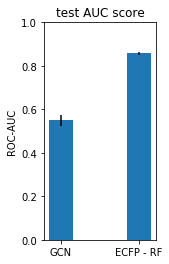

In [10]:
GCN_mean = np.mean(np.array(GCN_AUC_list))
GCN_std = np.std(np.array(GCN_AUC_list))

ECFP_mean = np.mean(np.array(ECFP_AUC_list))
ECFP_std = np.std(np.array(ECFP_AUC_list))


fig = plt.figure(figsize=(2, 4))
plt.title("test AUC score")
y = [GCN_mean, ECFP_mean]
x = ['GCN', 'ECFP - RF']
plt.bar(x, y, width=0.3, yerr = [GCN_std, ECFP_std])
plt.ylim((0, 1))
plt.ylabel("ROC-AUC")
plt.show()